In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [19]:
wf = open('npypaths_MemNets.csv', 'w')
wf.write('experiment,model,npypath\n')
for root, dirs, files in os.walk('../save_hurricane-poi'):
    for file in files:
        if file == 'GMAN_groundtruth.npy':
            modelname = 'GroundTruth'
            experiment = root.split('\\')[-1].split('_')[0]
            wf.write(','.join([experiment, modelname, os.path.join(root, file)]) + '\n')
        elif '_prediction.npy' in file:
            modelname = root.split('\\')[-1].split('_')[1]
            #if modelname=='TransformerT': modelname='Transformer'
            if modelname=='GraphWaveNetT': modelname='GW-Net'
            if modelname=='CopyLastWeekPlus1': modelname='CopyLastWeek'
            if modelname=='MemoryAGCRN': modelname='MemeSTN'
            experiment = root.split('\\')[-1].split('_')[0]
            wf.write(','.join([experiment, modelname, os.path.join(root, file)]) + '\n')
        else:
            pass

wf.close()

In [47]:
df_npypath = pd.read_csv('npypaths_MemNets.csv')
df_npypath

,experiment,model,npypath
0,hurricane-poi,AGCRN,../save_hurricane-poi\hurricane-poi_AGCRN_2022...
1,hurricane-poi,ASTGCN,../save_hurricane-poi\hurricane-poi_ASTGCN_202...
2,hurricane-poi,CopyLastWeek,../save_hurricane-poi\hurricane-poi_CopyLastWe...
3,hurricane-poi,DCRNN,../save_hurricane-poi\hurricane-poi_DCRNN_2022...
4,hurricane-poi,GroundTruth,../save_hurricane-poi\hurricane-poi_GMAN_20221...
5,hurricane-poi,GMAN,../save_hurricane-poi\hurricane-poi_GMAN_20221...
6,hurricane-poi,GW-Net,../save_hurricane-poi\hurricane-poi_GraphWaveN...
7,hurricane-poi,HistoricalAverage,../save_hurricane-poi\hurricane-poi_Historical...
8,hurricane-poi,LSTNet,../save_hurricane-poi\hurricane-poi_LSTNet_202...
9,hurricane-poi,MemeSTNnoise,../save_hurricane-poi\hurricane-poi_MemeSTNnoi...


In [16]:
for i in df_npypath[df_npypath.model=='CopyLastWeek']['npypath']:
    print(i)

../save_hurricane-poi\hurricane-poi_CopyLastWeekPlus1_202210110132_paper\CopyLastWeekPlus1_prediction.npy


GroundTruth
npy.shape, npy.min(), npy.max() (344, 6, 67) 0.0 43098.0
CopyLastWeek
npy.shape, npy.min(), npy.max() (344, 6, 67) 0.0 47587.0
GW-Net
npy.shape, npy.min(), npy.max() (344, 6, 67) -206.82228 35007.504
GMAN
npy.shape, npy.min(), npy.max() (344, 6, 67) -1611.963 44438.227
MemeSTN
npy.shape, npy.min(), npy.max() (344, 6, 67) 0.16402477 43961.062
test_times.shape (341, 12)
(344, 5, 3) (341,) 2019-08-27 08:00:00 2019-09-10 12:00:00


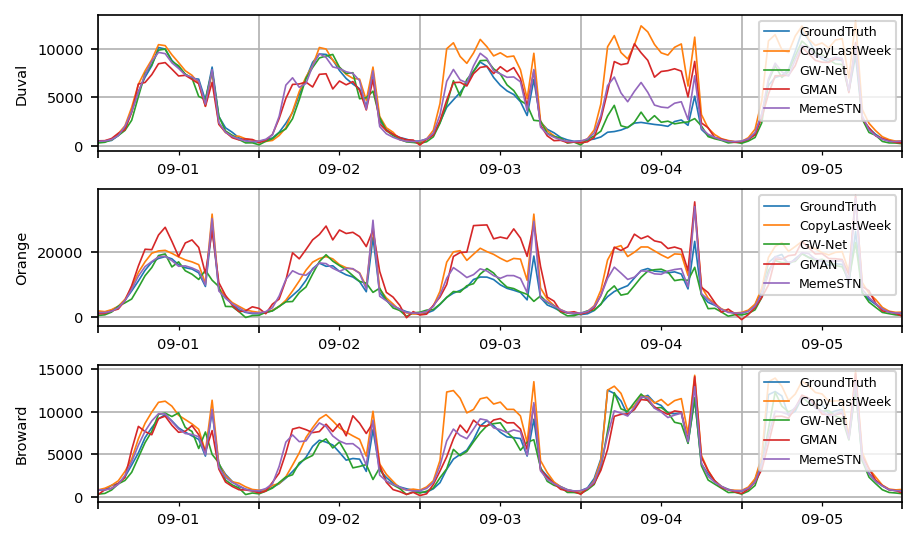

In [49]:
from Utils import *
from configparser import ConfigParser
import matplotlib.dates as mdates

def get_npys(exp, models, npypath='npypaths_MemNets.csv'):
    df_npypath = pd.read_csv(npypath)
    npy_list = []
    for model in models:
        print(model)
        path = df_npypath[(df_npypath.experiment==exp)&(df_npypath.model==model)]['npypath'].values[0]
        npy = np.load(path)
        print('npy.shape, npy.min(), npy.max()', npy.shape, npy.min(), npy.max())
        npy_list.append(npy)
    return npy_list

def get_times(exp):
    config = ConfigParser()
    config.read('params.txt', encoding='UTF-8')
    freq = config[exp]['freq']
    target_start_date = config[exp]['target_start_date']
    target_end_date = config[exp]['target_end_date']
    target_all_times = [date.strftime('%Y-%m-%d %H:%M:%S') for date in pd.date_range(start=target_start_date, end=target_end_date, freq=freq)]
    target_all_times = np.array(target_all_times)
    _, test_times = getXSYS(target_all_times, 'test', 12, 12, 0.8)    # todo: seq_len 6 6?
    print('test_times.shape', test_times.shape)
    return test_times

def prepare_data(exp, models, prefectures, time_step_id):  
    prefectureids = get_pref_id('../data/Florida_counties.csv', prefectures)
    npy_list = get_npys(exp, models)
    test_times = get_times(exp)
    for i in range(len(npy_list)):
        npy_list[i] = npy_list[i][:, time_step_id, prefectureids]
        npy_list[i] = npy_list[i][:, np.newaxis, :]
#         if i==2:    # for GMAN horizon=12
#             npy_list[i] = np.concatenate([npy_list[i][3:]]+[npy_list[i][0][np.newaxis]]*6, axis=0)
#         print(npy_list[i].shape)
    npy_list = np.concatenate(npy_list, axis=1)
    test_times = test_times[:, time_step_id]
    return npy_list, test_times

def plot_hurricane(exp, prefectures, fdata, test_times, start_date, end_date):
    words = exp.split('-')
    words[0] = words[0].capitalize()
    words[1] = words[1].capitalize()
    exp_tmp = ' '.join(words)
    
    start_index, end_index = test_times.tolist().index(start_date), test_times.tolist().index(end_date)
    xdata = pd.to_datetime(test_times[start_index:end_index+1])
    fdata = fdata[start_index:end_index+1]
    
    fontsize = 7
    num_row = 3
    fig = plt.figure(figsize=(6, 3.5),  constrained_layout=True, dpi=150)
    axes = fig.subplots(num_row, 1, sharex=False, gridspec_kw={'hspace': 0.01})
    
    for area_idx in range(len(prefectures)):
        ax = axes[area_idx]
        ax.plot(xdata, fdata[:, :, area_idx], lw=0.8)
        ax.legend(labels=models, loc='upper right', fontsize=6)
        ax.set_ylabel(prefectures[area_idx], fontsize=fontsize) #fontweight='bold'
        ax.grid(which='major', zorder=1)
        # if area_idx == 0:
        #     ax.vlines(mdates.datestr2num('2019-10-12 19:00:00'), 0, fdata[:, :, area_idx].max(), colors='r', lw=1, linestyles='--', zorder=4)
        #     # Add landfall labels
        #     ax.text(0.5, 1, 'Typhoon Landfall', verticalalignment ='bottom', horizontalalignment ='left', transform = ax.transAxes, fontsize=fontsize)
        ax.tick_params(axis='x', labelsize=fontsize)
        ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[0])) # 10-11 00：00
        ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[12])) # 10-11 12：00
        ax.xaxis.set_major_formatter(mdates.DateFormatter('')) # 10-11 00：00
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m-%d')) # 10-11 12：00
        ax.tick_params(which='minor', labelsize=fontsize)
        ax.tick_params(axis='y', labelsize=fontsize)
        plt.setp(ax.xaxis.get_minorticklabels(), rotation=0)
        ax.set_xlim([xdata[0], xdata[-1]])

    plt.savefig('TruthPred_{}_{}3.png'.format(words[0], words[1]))
    
############## Final Paper 2022/02/13 22:56:00
exp = 'hurricane-poi'
models = ['GroundTruth', 'CopyLastWeek', 'GW-Net', 'GMAN', 'MemeSTN']
prefectures = ['Duval', 'Orange', 'Broward']
time_step_id = 0    # future 1, 2, ..., 6 hours
fdata, times = prepare_data(exp, models, prefectures, time_step_id)
print(fdata.shape, times.shape, times[0], times[-1])
plot_hurricane(exp, prefectures, fdata, times, '2019-09-01 00:00:00', '2019-09-06 00:00:00')    # 3 days

GroundTruth
npy.shape, npy.min(), npy.max() (584, 6, 47) 102.99999999999997 160730.0
CopyLastWeek
npy.shape, npy.min(), npy.max() (584, 6, 47) 103.0 160730.0
GW-Net
npy.shape, npy.min(), npy.max() (584, 6, 47) -3084.1284 182391.55
GMAN
npy.shape, npy.min(), npy.max() (584, 6, 47) -1477.9227 165739.58
MemeSTN
npy.shape, npy.min(), npy.max() (584, 6, 47) 149.98009 171499.58
test_times.shape (581, 12)
(584, 5, 6) (581,) 2019-10-06 08:00:00 2019-10-30 12:00:00


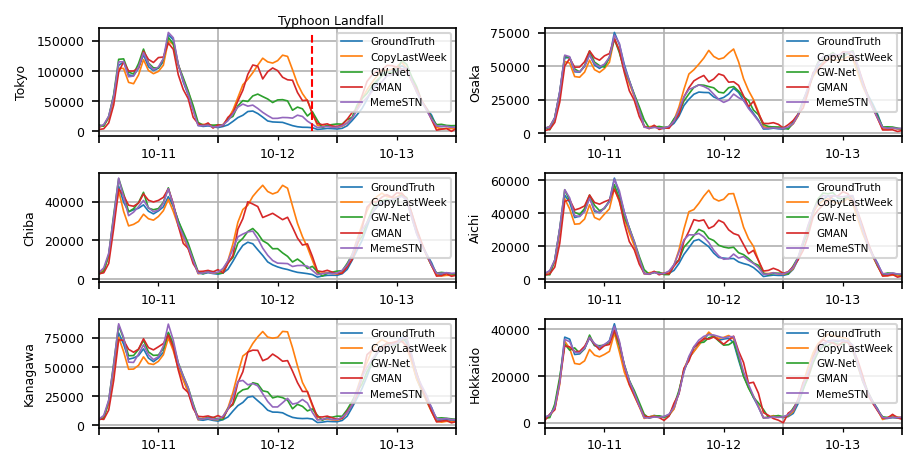

In [91]:
def plot_typhoon(exp, prefectures, fdata, test_times, start_date, end_date):
    words = exp.split('-')
    words[0] = words[0].capitalize()
    words[1] = words[1].capitalize()
    exp_tmp = ' '.join(words)
    
    start_index, end_index = test_times.tolist().index(start_date), test_times.tolist().index(end_date)
    xdata = pd.to_datetime(test_times[start_index:end_index+1])
    fdata = fdata[start_index:end_index+1]
    
    num_column = 2
    fig = plt.figure(figsize=(6, 3),  constrained_layout=True, dpi=150)
    axes = fig.subplots(len(prefectures)//num_column, num_column, sharex=False, gridspec_kw={'hspace': 0.01})

    for area_idx in range(len(prefectures)):
        x, y = area_idx//num_column, area_idx%num_column 
        ax = axes[x, y]
        ax.plot(xdata, fdata[:, :, area_idx], lw=0.8)
        ax.legend(labels=models, loc='upper right', fontsize=5)
        ax.set_ylabel(prefectures[area_idx], fontsize=6) #fontweight='bold'
        ax.grid(which='major', zorder=1)
        if area_idx == 0:
            ax.vlines(mdates.datestr2num('2019-10-12 19:00:00'), 0, fdata[:, :, area_idx].max(), colors='r', lw=1, linestyles='--', zorder=4)
            # Add landfall labels
            ax.text(0.5, 1, 'Typhoon Landfall', verticalalignment ='bottom', horizontalalignment ='left', transform = ax.transAxes, fontsize=6)
        ax.tick_params(axis='x', labelsize=6)
        ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[0])) # 10-11 00：00
        ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[12])) # 10-11 12：00
        ax.xaxis.set_major_formatter(mdates.DateFormatter('')) # 10-11 00：00
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m-%d')) # 10-11 12：00
        ax.tick_params(which='minor', labelsize=6)
        ax.tick_params(axis='y', labelsize=6)
        plt.setp(ax.xaxis.get_minorticklabels(), rotation=0)
        ax.set_xlim([xdata[0], xdata[-1]])

    plt.savefig('TruthPred_{}_{}3_vertical.png'.format(words[0], words[1]))
    
############## Final Paper 2022/02/13 22:56:00
exp = 'typhoon-outflow'
models = ['GroundTruth', 'CopyLastWeek', 'GW-Net', 'GMAN', 'MemeSTN']
prefectures = ['Tokyo', 'Osaka', 'Chiba', 'Aichi', 'Kanagawa', 'Hokkaido']
time_step_id = 0 # future 1, 2, ..., 6 hours
fdata, times = prepare_data(exp, models, prefectures, time_step_id)
print(fdata.shape, times.shape, times[0], times[-1])
plot_typhoon(exp, prefectures, fdata, times, '2019-10-11 00:00:00', '2019-10-14 00:00:00') # 14 days